# Inleiding

Bij het beheer en onderhoud van HB Havens in November 2023 was melding gemaakt van een bug in het afhandelen van golfbreking. Nadere analyse wees uit dat dit niet zozeer een bug was, als wel onbegrip over de wijze waarop golfbreking wordt afgehandeld en in de resultaten wordt opgenomen.

In dit notebook wordt op een gestructureerde wijze gekeken wat het effect van golfbreking is op de uitkomsten. Hiertoe wordt HB Havens voor een gegeven schematisatie (in dit notebook Riete) gerund met verschillende combinaties van processen. Tot slot wordt voor een gekozen tweetal combinaties een figuur gemaakt van de significante golfhoogte zonder (Hs,totaal) en met (Hs,out) golfbreking. Hiermee kan de gebruiker onagaan of golfbreking is toegepast en op hooflijnen wat het effect is.

# Imports

In [1]:
import sys
import os
import shutil
# import copy
import matplotlib.pyplot as plt
import pandas as pd

owd = os.getcwd()
testdir = os.path.dirname(owd)
sys.path.append(testdir)
trunkdir = os.path.dirname(testdir)
sys.path.append(trunkdir)

import common
from hbhavens.core.models import MainModel

# Schematisatie

In [2]:
case = 'riette'
datadir = os.path.join(trunkdir, 'tests', 'data', case)
paths = {
    'harborarea': os.path.join(datadir, 'shapes', 'haventerrein.shp'),
    'breakwater': os.path.join(datadir, 'shapes', 'havendammen.shp'),
    'hrd': os.path.join(datadir, 'databases', 'WBI2017_IJsseldelta_11-2_v01_steunpunt.sqlite'),
    'config': os.path.join(datadir, 'databases', 'WBI2017_IJsseldelta_11-2_v01_steunpunt.config.sqlite'),
    'result_locations': os.path.join(datadir, 'shapes', 'uitvoerlocaties.shp'),
    'hlcd': os.path.join(datadir, '..', 'hlcd.sqlite'),
}
trajecten = ['11-2']
bedlevel = -5.0
supportlocation = 'IJ_1_11-2_dk_00210'

# Create and run for various combinations of processes

In [3]:
tempdir = os.path.join(os.path.dirname(trunkdir),'temp')
if os.path.isdir(tempdir):
    shutil.rmtree(tempdir)
os.mkdir(tempdir)

In [4]:
combinations = {
    'none': None,
    'g': ['Lokale golfgroei'],
    'gt': ['Lokale golfgroei', 'Transmissie'],
    'gd': ['Lokale golfgroei', 'Diffractie'],
    'gb': ['Lokale golfgroei', 'Golfbreking'],
    'gtd': ['Lokale golfgroei', 'Transmissie', 'Diffractie'],
    'gtb': ['Lokale golfgroei', 'Transmissie', 'Golfbreking'],
    'gdb': ['Lokale golfgroei', 'Diffractie', 'Golfbreking'],
    'all': ['Lokale golfgroei', 'Transmissie', 'Diffractie', 'Golfbreking'],
}

In [5]:
for combination in combinations:
    print(combination)
    print(combinations[combination])

    model = MainModel()
    model.project.settings['project']['name'] = case
    model.project.settings['project']['user']['email'] = 'benit@hkv.nl'
    model.project.settings['project']['user']['name'] = 'Matthijs Bénit'
    model.project.save_as(os.path.join(tempdir, case + '_' + combination + '.json'))

    common.add_schematisation(model, paths=paths, supportlocationname=supportlocation, trajecten=trajecten, bedlevel=bedlevel)

    model.project.settings['hydraulic_loads']["recalculate_waterlevels"] = True
    model.project.settings['hydraulic_loads']["waterlevels"].extend([-0.5, 1.8, 1.95, 3.0, 3.5, 5.0, 6.5])
    model.project.settings['hydraulic_loads']['recalculate_method'] = 'interpolation'

    # Calculate waterlevels
    model.hydraulic_loads.calculate_waveconditions()
    model.hydraulic_loads.adapt_interpolated()

    # Calculate wave processes
    model.simple_calculation.run_all(processes=combinations[combination])
    model.simple_calculation.combinedresults.run(combinations[combination])
    model.simple_calculation.mainmodel.project.settings['simple']['finished'] = True
    model.simple_calculation.save_results()

    # Save results
    model.project.save()
    model.save_tables()

none
None
g
['Lokale golfgroei']
gt
['Lokale golfgroei', 'Transmissie']
gd
['Lokale golfgroei', 'Diffractie']
gb
['Lokale golfgroei', 'Golfbreking']
gtd
['Lokale golfgroei', 'Transmissie', 'Diffractie']
gtb
['Lokale golfgroei', 'Transmissie', 'Golfbreking']
gdb
['Lokale golfgroei', 'Diffractie', 'Golfbreking']
all
['Lokale golfgroei', 'Transmissie', 'Diffractie', 'Golfbreking']


(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

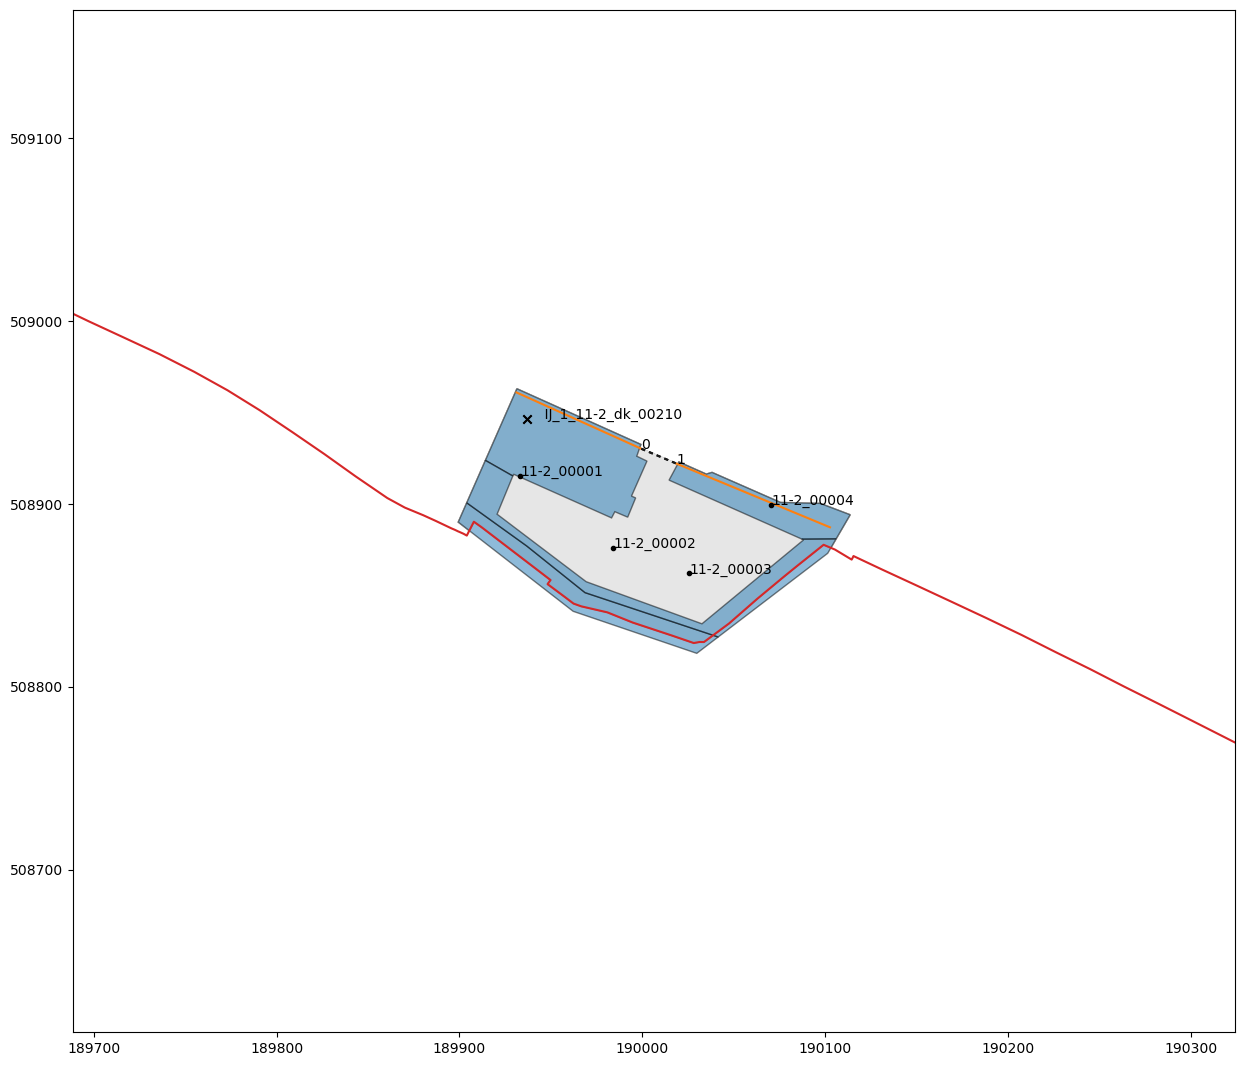

In [6]:
model.schematisation.plot_schematisation()


# Visualise differences

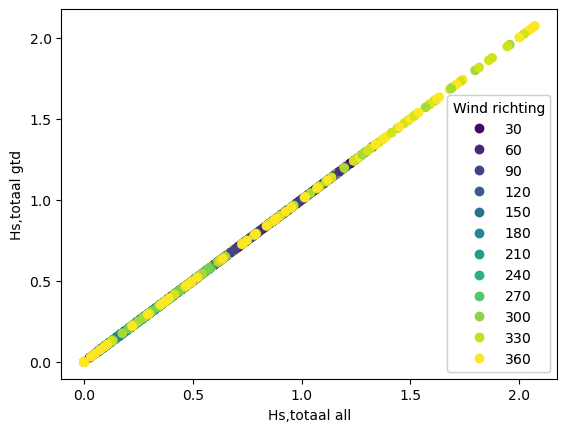

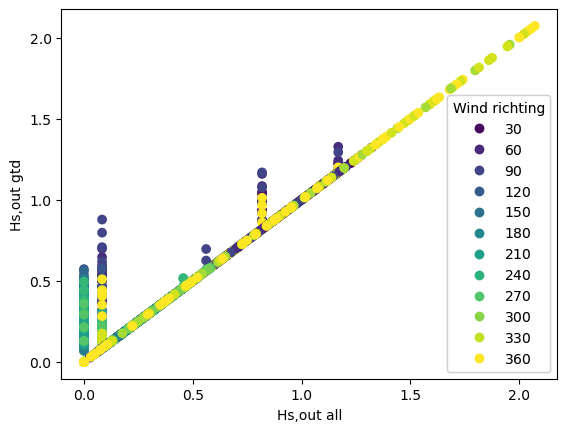

In [7]:
# params = ['Ed', 'Et', 'Ed,t', 'Elg', 'Etotaal', 'Hs,totaal', 'Hs,max', 'Hs,out']
params = ['Hs,totaal', 'Hs,out']

schematisatie1 = 'all'
schematisatie2 = 'gtd'

results = pd.DataFrame()
for schematisatie in [schematisatie1, schematisatie2]:
    model = MainModel()
    model.project.open_from_file(os.path.join(tempdir, case + '_' + schematisatie + '.json'))
    model.simple_calculation.load_results()

    model.simple_calculation.combinedresults.output.columns = schematisatie + '_' + model.simple_calculation.combinedresults.output.columns
    results = pd.concat([results,model.simple_calculation.combinedresults.output], axis=1)

for i,par in enumerate(params):
    fig, ax = plt.subplots()
    scatter = ax.scatter(results[schematisatie1 + '_' + par],results[schematisatie2 + '_' + par], c=results['all_Wind direction'])
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Wind richting")
    ax.add_artist(legend1)
    ax.set_xlabel(par + ' ' + schematisatie1)
    ax.set_ylabel(par + ' ' + schematisatie2)
    plt.show()
